In [2]:
import pandas as pd
import numpy as np
import ast

In [95]:
scene_events_df = pd.read_csv('feat_ablation_sceneXevents_0.csv')

for i, row in scene_events_df.iterrows():
    row['feat_ablation_preds'] = ast.literal_eval(row['feat_ablation_preds'])
    row['scene_events'] = ast.literal_eval(row['scene_events'])
    row['feat_ablation_events'] = ast.literal_eval(row['feat_ablation_events'])

In [46]:
scapper_scenes = scene_events_df['acoustic_scene_label'].unique()
feat_ablation_scene_preds = {scene:[0 for i in range(16)] for scene in scapper_scenes}

for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    #print(row['feat_ablation_preds'])
    for j in range(len(row['feat_ablation_preds'])):
        if scene != row['feat_ablation_preds'][j]:
            feat_ablation_scene_preds[scene][j] += 1

In [97]:
feat_ablation_indices = {scene:[] for scene in scapper_scenes}

for scene in scapper_scenes:
    feat_ablation_indices[scene] = [i for i in range(len(feat_ablation_scene_preds[scene])) if feat_ablation_scene_preds[scene][i] >= 15]

In [144]:
import collections

all_events = set()

for i, row in scene_events_df.iterrows():
    for j in row['feat_ablation_events']:
        for k in range(len(j)):
            all_events.add(j[k])

for i, row in scene_events_df.iterrows():
    for j in row['scene_events']:
        all_events.add(j)

scene_wise_event_counts = collections.defaultdict(dict)
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = collections.defaultdict(dict)
    for i in (list)(all_events):
        scene_wise_event_counts[scene][i] = 0
    for j in scene_events_df[scene_events_df['acoustic_scene_label']==scene]['scene_events']:
        for k in range(len(j)):
            #print(k)
            scene_wise_event_counts[scene][j[k]] += 1

In [145]:
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = sorted(scene_wise_event_counts[scene].items(), key=lambda item: item[1], reverse=True)

In [147]:
events_freq = {event:0 for event in all_events}

for i in scene_events_df['scene_events']:
    for j in i:
        events_freq[j] += 1

events_freq = sorted(events_freq.items(), key=lambda item: item[1], reverse=True)

In [20]:
'''scapper_scenes - all scenes
all_events - all events
scene_events_df - acoustic_scene_label, audio_fname, feat_ablation_preds, scene_events, feat_ablation_events
events_freq - frequency of all the events present in all the scenes
scene_wise_event_counts - count of each event in each scene
feat_ablation_indices - indices of feat columns that when ablated, changes the preds (indices of important features found after feature ablation)
'''

'scapper_scenes - all scenes\nall_events - all events\nscene_events_df - acoustic_scene_label, audio_fname, feat_ablation_preds, scene_events, feat_ablation_events\nevents_freq - frequency of all the events present in all the scenes\nscene_wise_event_counts - count of each event in each scene\nfeat_ablation_indices - indices of feat columns that when ablated, changes the preds (indices of important features found after feature ablation)\n'

In [149]:
from collections import defaultdict

diff_events_dict = defaultdict(dict)

for scene in scapper_scenes:
    diff_events_dict[scene] = defaultdict(dict)
    for indices in feat_ablation_indices[scene]:
        diff_events_dict[scene][indices] = {i:0 for i in (list)(all_events)}
        #print(scene, indices)

for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    tru_events = row['scene_events']
    pred_events = row['feat_ablation_events']
    #print(scene, len(pred_events))
    for j in range(len(pred_events)):
        seti = set(pred_events[j])
        setj = set(tru_events)
        diff_list = list(seti.symmetric_difference(setj))

        if len(diff_list) > 0:
            for k in diff_list:
                ind = feat_ablation_indices[scene][j]
                #print(scene, ind, k)
                diff_events_dict[scene][ind][k] += 1

for scene in scapper_scenes:
    for indices in feat_ablation_indices[scene]:
        diff_events_dict[scene][indices] = sorted(diff_events_dict[scene][indices].items(), key=lambda item: item[1], reverse=True)   

In [152]:
events_based_on_freq = defaultdict(dict)
events_based_on_scene = defaultdict(dict)

for scene in scapper_scenes:
    events_based_on_scene[scene] = defaultdict(dict)
    for i in feat_ablation_indices[scene]:
        events_based_on_freq[i] = defaultdict(dict)
        for j in (list)(all_events):
            events_based_on_freq[i][j] = 0
    for k in (list)(all_events):
        events_based_on_scene[scene][k] = 0

In [153]:
for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    tru_events = row['scene_events']
    pred_events = row['feat_ablation_events']
    for j in range(len(pred_events)):
        for k in tru_events:
            if k not in pred_events[j]:
                ind = feat_ablation_indices[scene][j]
                events_based_on_freq[ind][k] += 1
                events_based_on_scene[scene][k] += 1

In [154]:
for scene in scapper_scenes:
    events_based_on_scene[scene] = sorted(events_based_on_scene[scene].items(), key=lambda item: item[1], reverse=True)

for indices in events_based_on_freq:
    events_based_on_freq[indices] = sorted(events_based_on_freq[indices].items(), key=lambda item: item[1], reverse=True)

In [155]:
import json
audioset_ontology_df = pd.read_json('audioset_ontology.json')
# name: event_label
# id: id of the current id
# child_ids: list of child event ids

def get_parent_eventClass(event_label):
    event_label_row = audioset_ontology_df.loc[audioset_ontology_df['name'] == event_label]
    event_id = (event_label_row['id'].to_string(index=False))
    
    temp = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    idx = temp.index
    
    if len(idx) > 0:
        return audioset_ontology_df['name'].iloc[idx[0]]
    else:
        return 'None'

all_parent_events = set()
for event in list(all_events):
    if get_parent_eventClass(event) == 'None':
        all_parent_events.add(event)
    else:
        all_parent_events.add(get_parent_eventClass(event))



In [181]:
scene_parent_eventClass_count = defaultdict(dict)

for scene in scapper_scenes:
    scene_parent_eventClass_count[scene] = defaultdict(dict)
    for i in (missed_events_dict):
        #scene_parent_eventClass_count[scene][i] = 0
        for j in (missed_events_dict[i]):
            for k in (missed_events_dict[i][j]):
                if k[1]>0:
                    parent_class = get_parent_eventClass(k[0])
                    if (parent_class not in scene_parent_eventClass_count[scene]) and (parent_class != 'None'):
                        scene_parent_eventClass_count[scene][parent_class] = 0
                    if parent_class == 'None' and (k[0] not in scene_parent_eventClass_count[scene]):
                        scene_parent_eventClass_count[scene][k[0]] = 0
                    if parent_class != 'None':
                        scene_parent_eventClass_count[scene][parent_class] += k[1]
                    else:
                        scene_parent_eventClass_count[scene][k[0]] += k[1]


In [ ]:


for scene in events_based_on_scene:
    for i in events_based_on_scene[scene]:
        parent_class = get_parent_eventClass(i[0])
        #print(parent_class, i[0])
        if parent_class != 'None':
            scene_parent_eventClass_count[scene][parent_class] += i[1]
        else:
            scene_parent_eventClass_count[scene][i[0]] += i[1]

<Axes: >

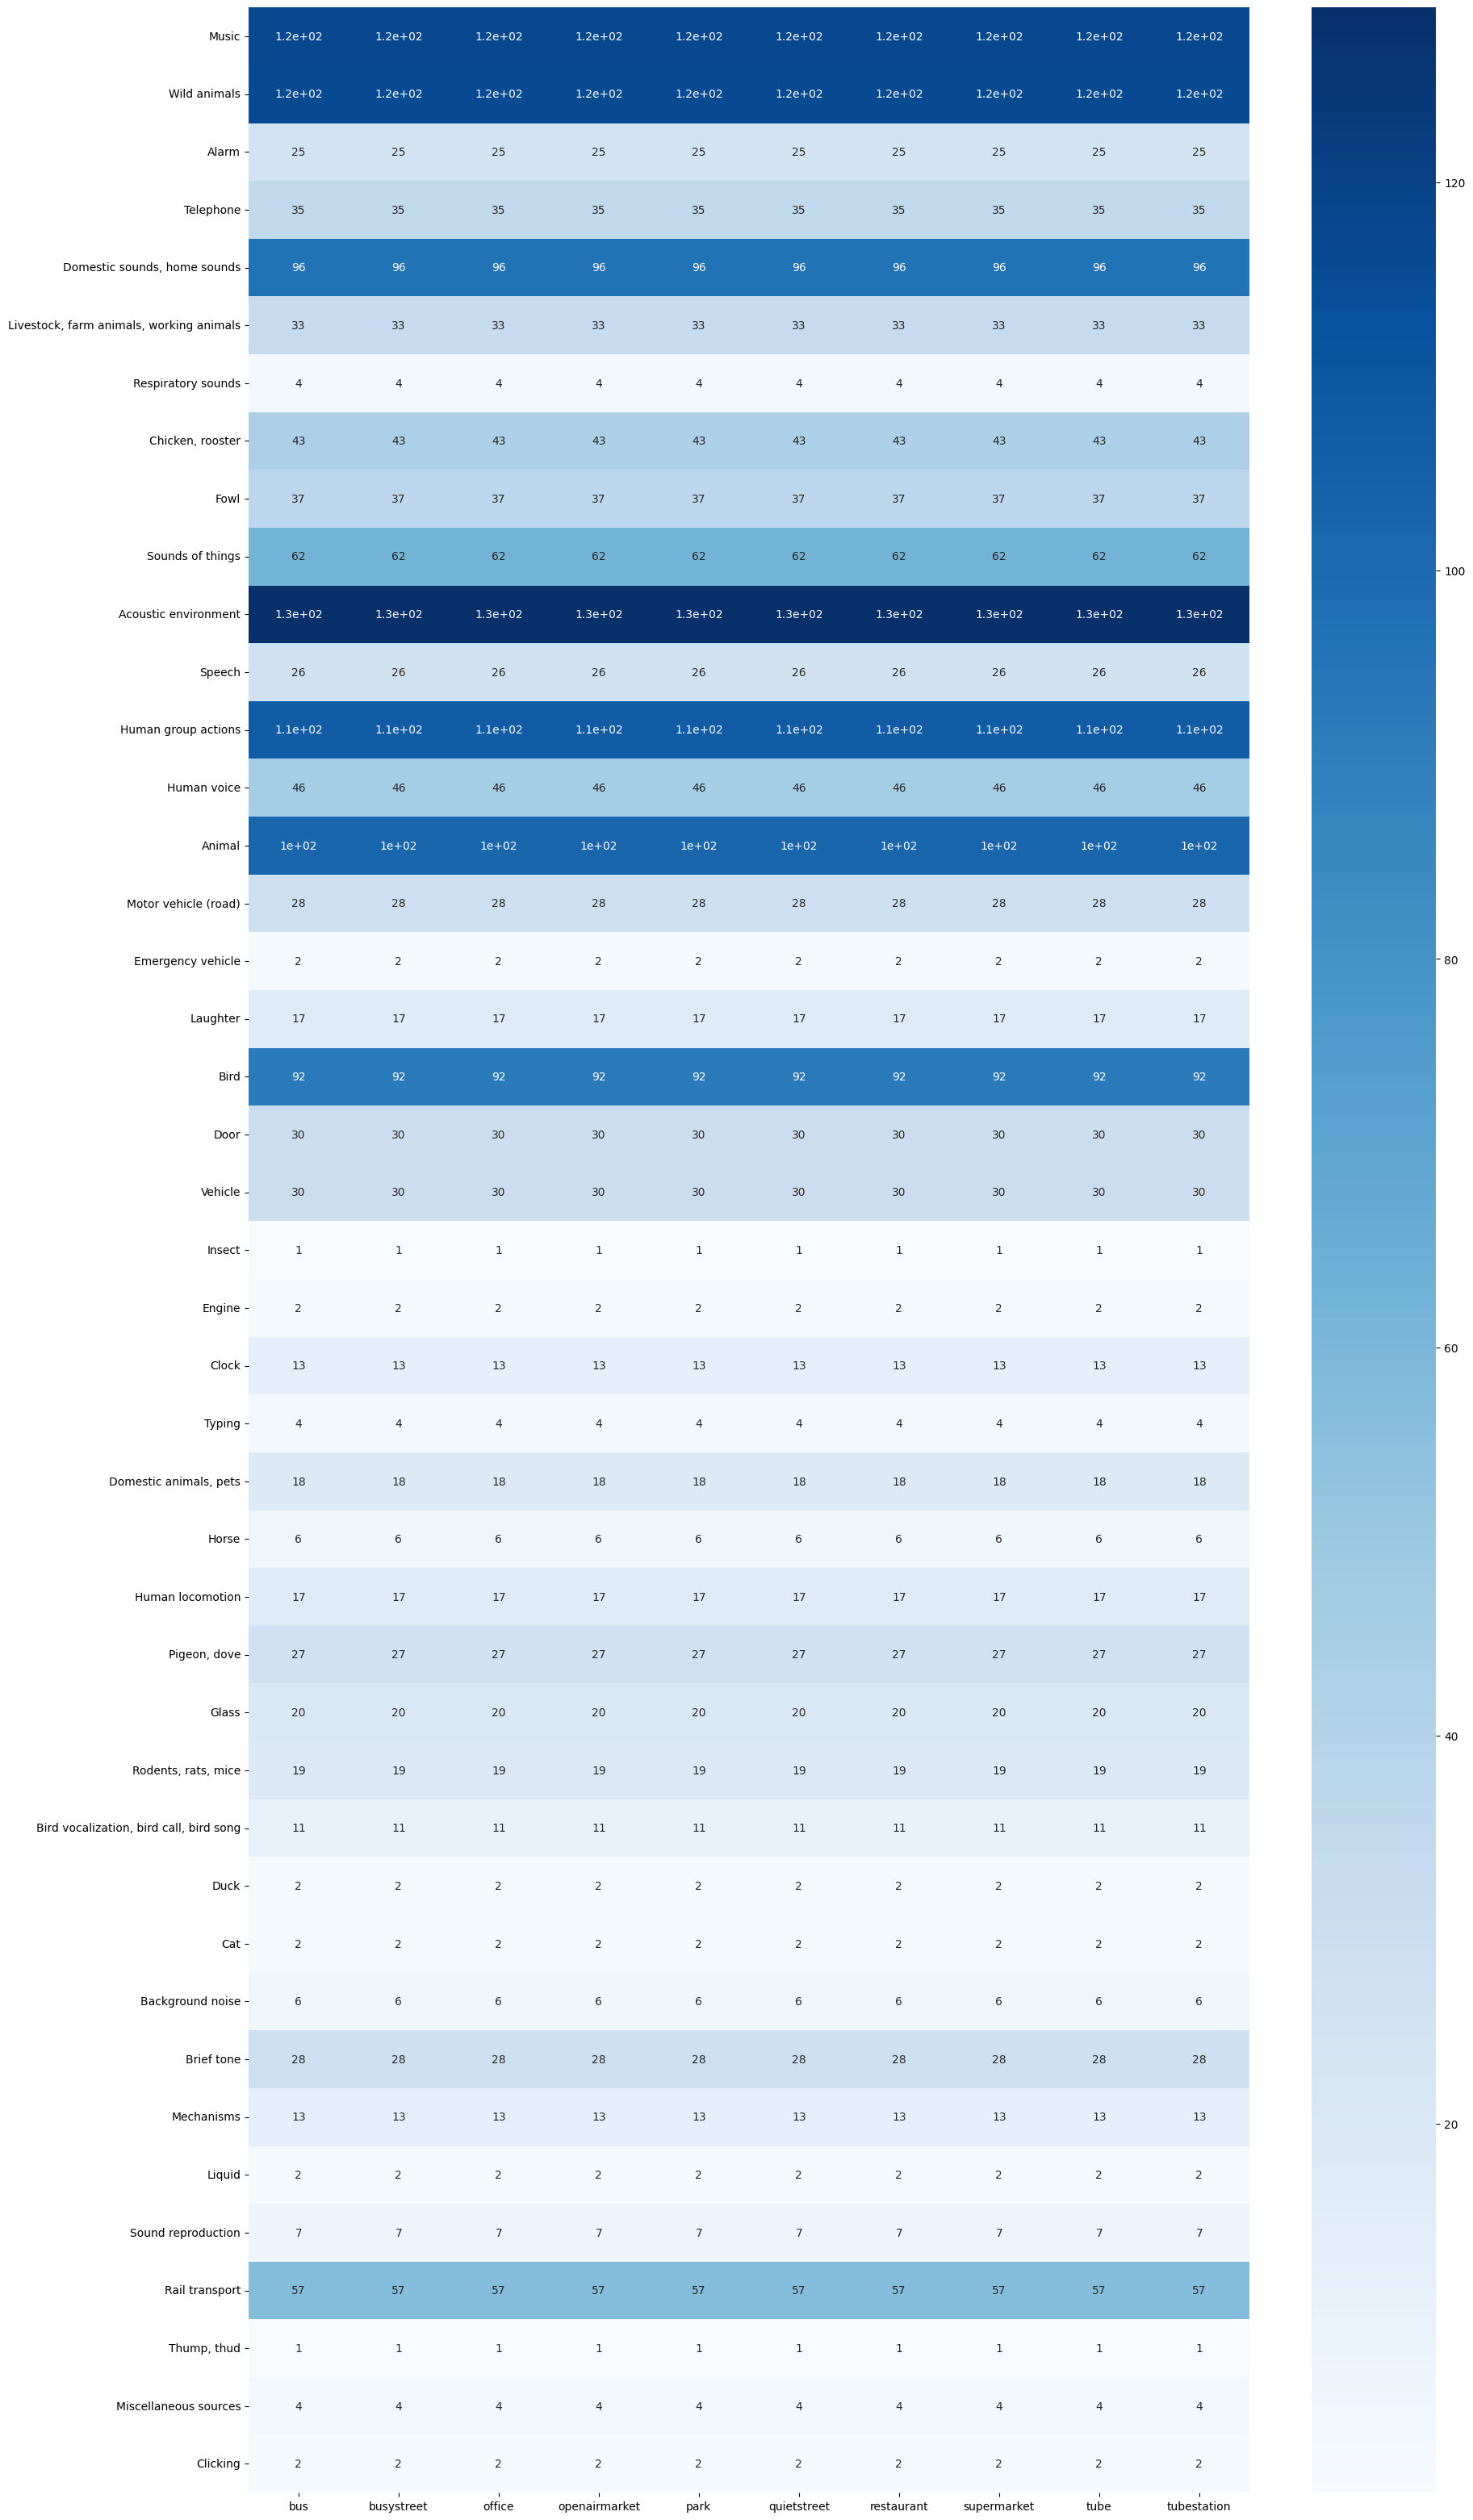

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 40))
sns.heatmap(pd.DataFrame(scene_parent_eventClass_count), annot=True, cmap='Blues')

<Axes: >

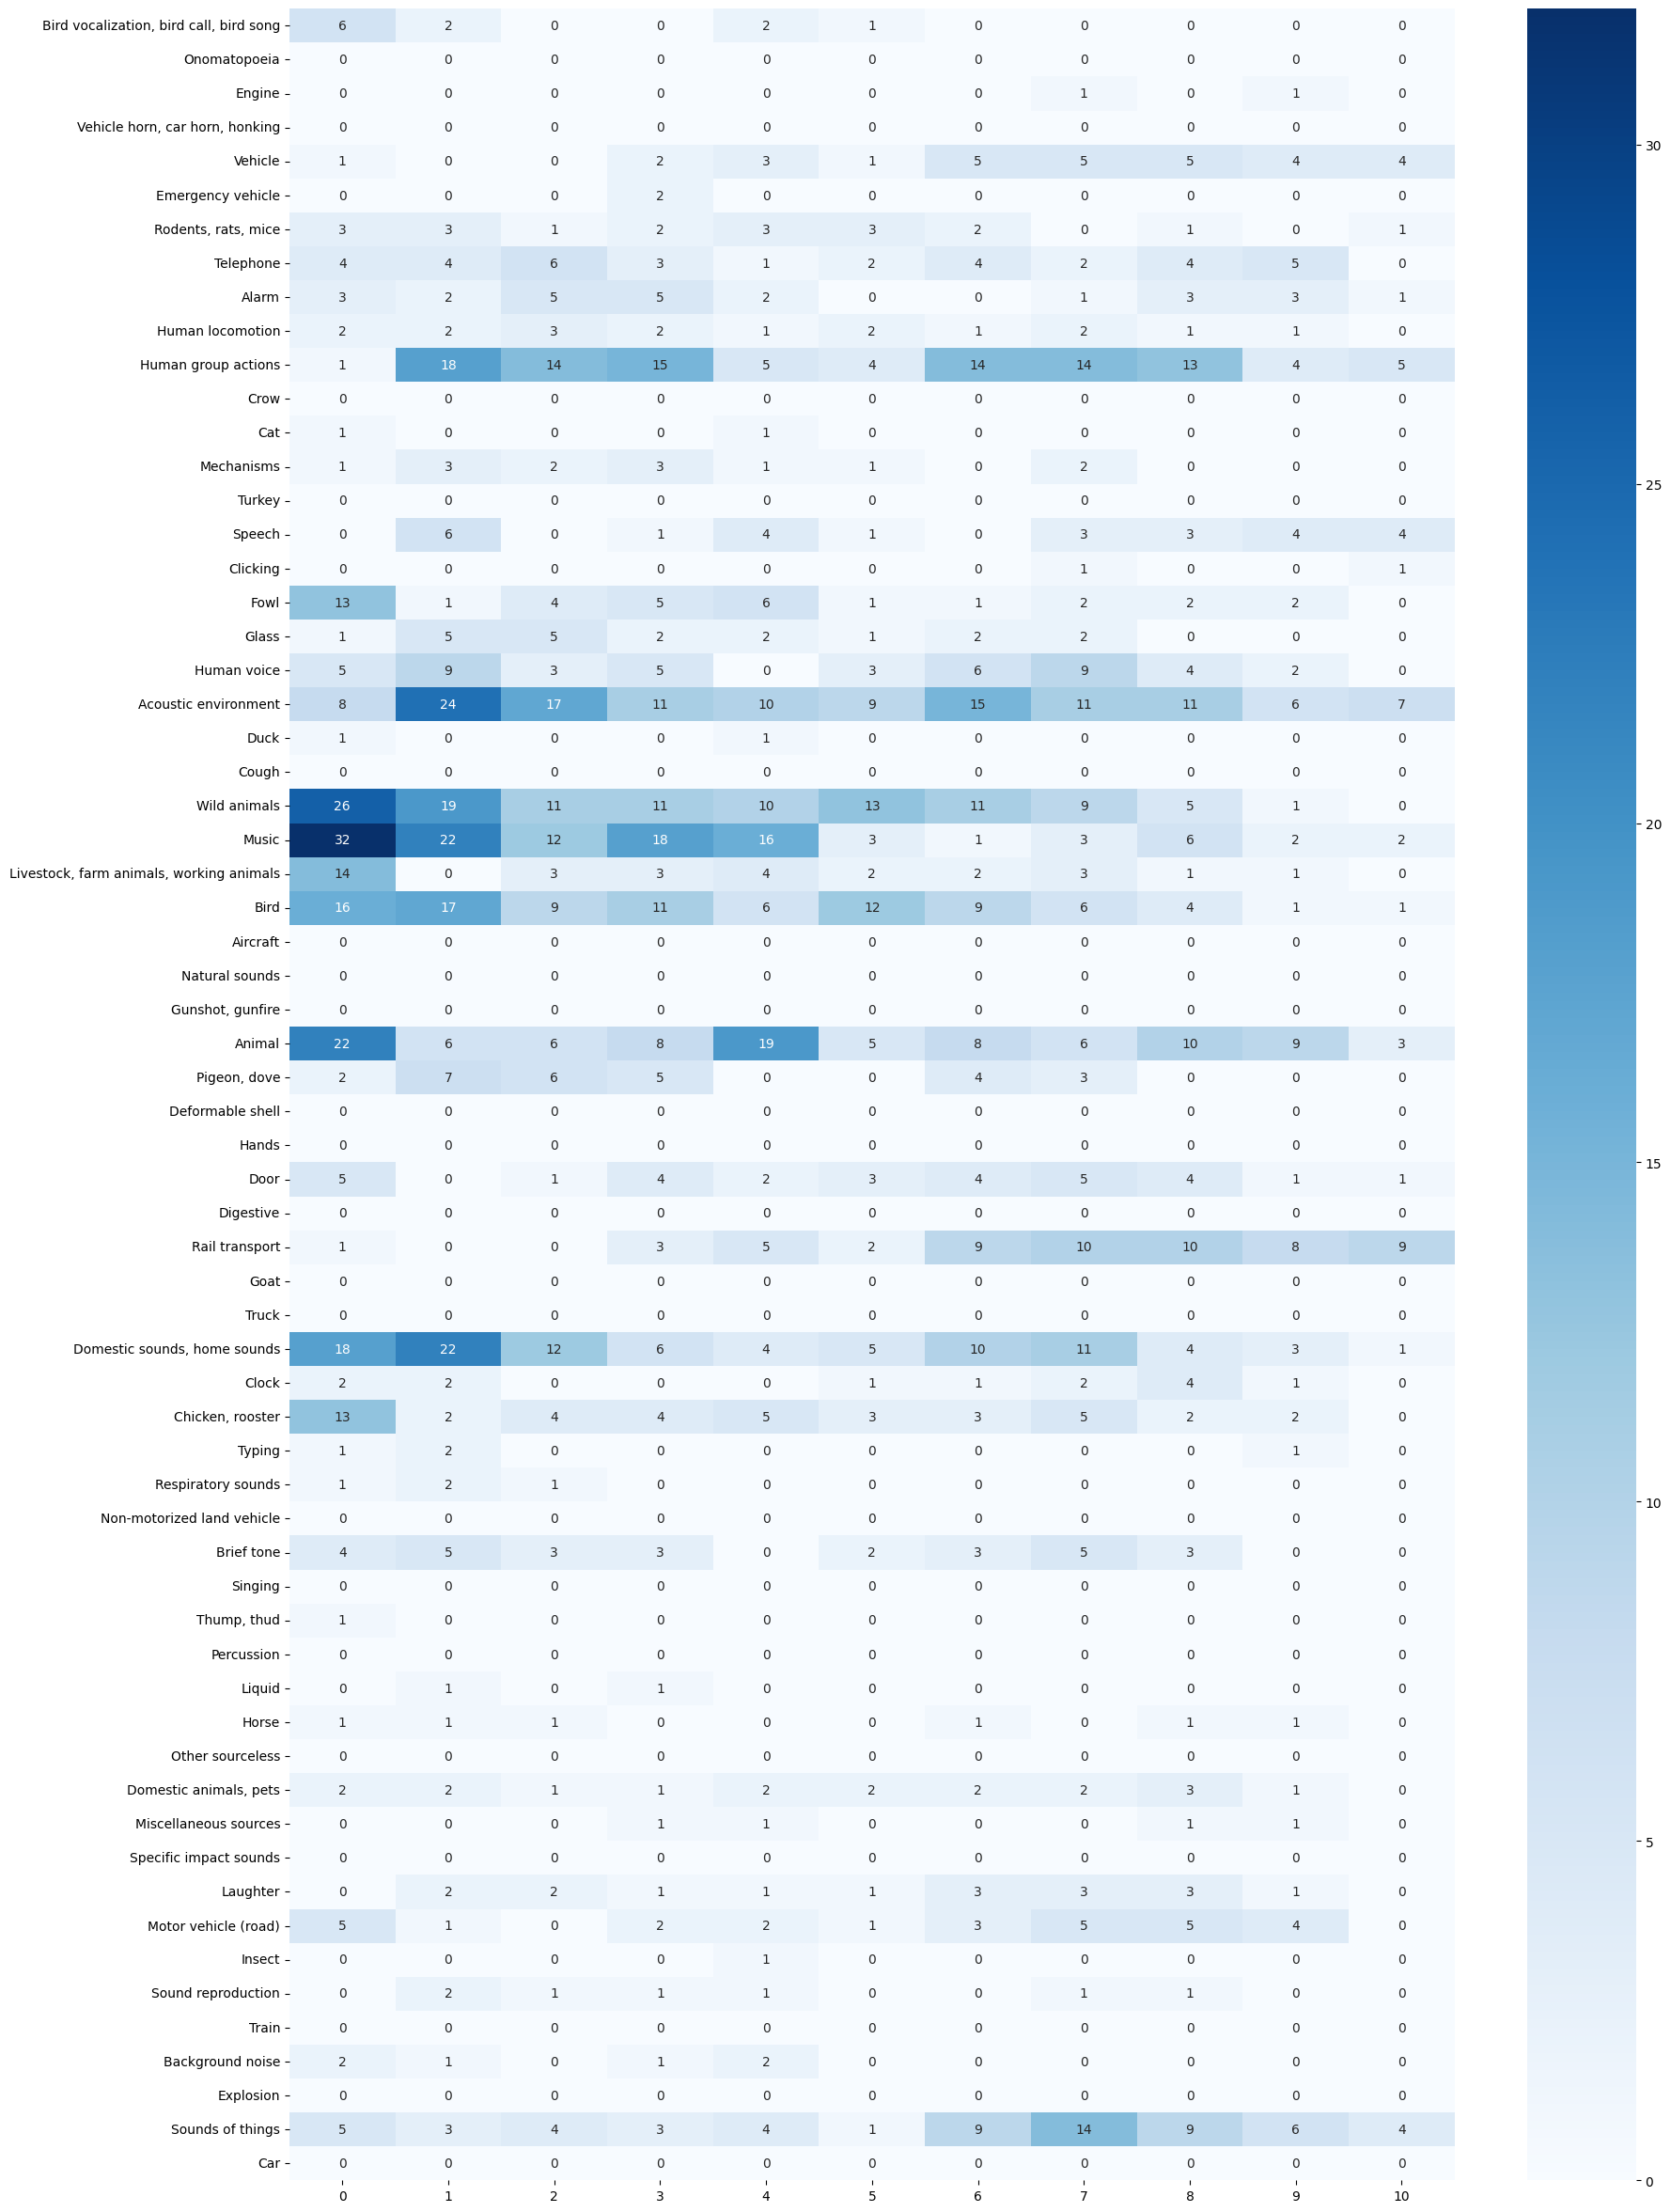

In [165]:
freq_parent_eventClass_count = defaultdict(dict)

for i in events_based_on_freq:
    freq_parent_eventClass_count[i] = defaultdict(dict)
    for j in (list)(all_parent_events):
        freq_parent_eventClass_count[i][j] = 0

for i in events_based_on_freq:
    for j in events_based_on_freq[i]:
        parent_class = get_parent_eventClass(j[0])
        if parent_class != 'None':
            freq_parent_eventClass_count[i][parent_class] += j[1]
        else:
            freq_parent_eventClass_count[i][j[0]] += j[1]

plt.figure(figsize=(20, 30))
sns.heatmap(pd.DataFrame(freq_parent_eventClass_count), annot=True, cmap='Blues')

In [48]:
missed_event_0 = set()

for i, row in scene_events_df[scene_events_df['acoustic_scene_label']=='busystreet'].iterrows():
    tru_ = row['scene_events']
    pred_ = row['feat_ablation_events'][1]
    for j in range(len(tru_)):
        if tru_[j] not in pred_:
            missed_event_0.add(tru_[j])

In [76]:
import collections

d = collections.defaultdict(dict)

for scene in scapper_scenes:
    d[scene] = {i:0 for i in (list)(all_events)}


SyntaxError: invalid syntax (4217839361.py, line 6)

In [1]:
import pandas as pd
import numpy as np
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels
import torch

import sys
sys.path.append("../ASC_AED_JoinTask/Datasets/")

import datasets

In [3]:
def string_to_list(events_string):
    if events_string == '[]':
        return []
    else:
        return_list = events_string[1:-1].split("', '")
        return_list[0] = return_list[0].split("'")[1]
        return_list[-1] = return_list[-1].split("'")[0]
        return return_list

In [4]:
scapper_df = pd.read_csv('../ASC_AED_JoinTask/predictions/scapper_preds/scrapper_test_panns_eventsInference.csv')
pred_events_col = 'scrapper_panns_inference_events_list'

In [5]:
scapper_df[pred_events_col].iloc[0]

"['Speech', 'Telephone bell ringing', 'Telephone', 'Music', 'Vehicle', 'Alarm clock', 'Inside, small room', 'Laughter', 'Giggle']"

In [6]:
all_events = set()

for index, row in enumerate(scapper_df[pred_events_col]):
    #print(row)
    event_list = string_to_list(row)
    for event in event_list:
        all_events.add(event)

In [7]:
import math

new_events_df = pd.DataFrame(index=(list)(all_events), columns=scapper_df['acoustic_scene_label'].unique())

for index, row in scapper_df.iterrows():
    #print(row['acoustic_scene_label'], row[pred_events_col])
    for i in string_to_list(row[pred_events_col]):
        if math.isnan(new_events_df[row['acoustic_scene_label']][i]):
            new_events_df[row['acoustic_scene_label']][i] = 0
        new_events_df[row['acoustic_scene_label']][i] += 1

new_events_df = new_events_df.fillna(0)

In [8]:
import seaborn as sns

scene_events_dict = {}

for scene in new_events_df.columns:
    scene_events_dict[scene] = new_events_df[scene][new_events_df[scene] > 0].sort_values(ascending=False)

/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


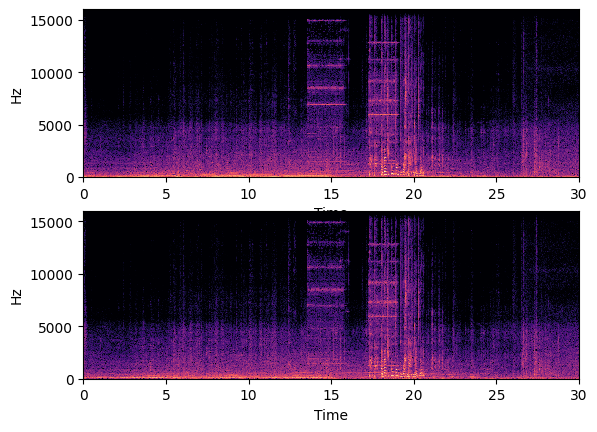

In [9]:
import panns_inference
import sys
import librosa
import os
sys.path.append("../ASC_AED_JoinTask/Datasets/")
import datasets
import audio_utils as au
from IPython.display import display, Audio
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
#model_path00 = '../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth'

sample = os.path.join(datasets.SCAPPER_AUD_DIR + 'test/', scapper_df['audio_fileNames'].iloc[0]) 
audio = au.load_audio_from_file(sample, sample_rate=au.SAMPLE_RATE)
#audio, sr = torchaudio.load(sample)
stf = librosa.stft(audio, n_fft=au.N_FFT, hop_length=au.HOP_LEN)
new = librosa.power_to_db(np.abs(stf)**2, ref=np.max)
log_mel = au.get_log_melSpectrogram(audio, n_fft=au.N_FFT, hop_len=au.HOP_LEN, n_mels=641)

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stf), ref=np.max), y_axis='linear', x_axis='time', sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, n_fft=au.N_FFT)
plt.subplot(2, 1, 2)
librosa.display.specshow(new, sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, x_axis='time', y_axis='linear', n_fft=au.N_FFT)
#display(Audio(audio, rate=au.SAMPLE_RATE))


In [121]:
(stf == log_mel.squeeze().numpy()).sum()

0

In [106]:
spec.shape

(257, 5168)